In [1]:
from pathlib import Path
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

ROOT = Path("..")
DATA_PROCESSED = ROOT / "data" / "processed" / "db1"
MODELS_DIR     = ROOT / "models" / "db1"
REPORTS_DIR    = ROOT / "reports" / "db1"
for p in [MODELS_DIR, REPORTS_DIR]:
    p.mkdir(parents=True, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [23]:
# --- Load as before ---
train_npz = DATA_PROCESSED / "dl_train_db1_raw.npz"
val_npz   = DATA_PROCESSED / "dl_val_db1_raw.npz"
test_npz  = DATA_PROCESSED / "dl_test_db1_raw.npz"

ztr = np.load(train_npz, allow_pickle=True)
zva = np.load(val_npz,   allow_pickle=True)
zte = np.load(test_npz,  allow_pickle=True)

Xtr, ytr = ztr["X"], ztr["y"]
Xva, yva = zva["X"], zva["y"]
Xte, yte = zte["X"], zte["y"]
idx_to_label = ztr["idx_to_label"]
n_classes = len(idx_to_label)
print("Train:", Xtr.shape, "Val:", Xva.shape, "Test:", Xte.shape, "classes:", n_classes)

# # --- Subsample for CPU demo ---
# # choose a fraction or a fixed number per split
# N_train, N_val, N_test = 2000, 500, 500   # adjust as needed

# rng = np.random.default_rng(seed=0)  # reproducible
# train_idx = rng.choice(len(Xtr), size=min(N_train, len(Xtr)), replace=False)
# val_idx   = rng.choice(len(Xva), size=min(N_val, len(Xva)), replace=False)
# test_idx  = rng.choice(len(Xte), size=min(N_test, len(Xte)), replace=False)

# Xtr, ytr = Xtr[train_idx], ytr[train_idx]
# Xva, yva = Xva[val_idx], yva[val_idx]
# Xte, yte = Xte[test_idx], yte[test_idx]

def stratified_cap(X, y, per_class=200, seed=0):
    rng = np.random.default_rng(seed)
    keep_idx = []
    for c in np.unique(y):
        idx = np.where(y == c)[0]
        if len(idx) == 0: 
            continue
        take = min(per_class, len(idx))
        keep_idx.extend(rng.choice(idx, size=take, replace=False))
    keep_idx = np.array(keep_idx)
    return X[keep_idx], y[keep_idx]

# after loading NPZs:
Xtr, ytr = stratified_cap(Xtr, ytr, per_class=400, seed=0)
Xva, yva = stratified_cap(Xva, yva, per_class=100, seed=1)
Xte, yte = stratified_cap(Xte, yte, per_class=100, seed=2)

# sanity: show class counts
for name, yv in [("train", ytr), ("val", yva), ("test", yte)]:
    vals, cnts = np.unique(yv, return_counts=True)
    print(name, "classes:", len(vals), "min/max per class:", cnts.min(), cnts.max())
    

print("Train:", Xtr.shape, "Val:", Xva.shape, "Test:", Xte.shape, "classes:", n_classes)

Train: (312643, 50, 10) Val: (93436, 50, 10) Test: (93476, 50, 10) classes: 23
train classes: 23 min/max per class: 400 400
val classes: 23 min/max per class: 100 100
test classes: 23 min/max per class: 100 100
Train: (9200, 50, 10) Val: (2300, 50, 10) Test: (2300, 50, 10) classes: 23


# Dataset & DataLoaders
Our NPZs are (N, T, C) (time, channels). CNN1D expects (N, C, T), so we’ll permute in __getitem__.

In [24]:
# class EMGWindowDataset(Dataset):
#     def __init__(self, X, y, channel_first=True):
#         self.X = X.astype(np.float32)
#         self.y = y.astype(np.int64)
#         self.channel_first = channel_first
#     def __len__(self): return self.X.shape[0]
#     def __getitem__(self, i):
#         x = self.X[i]  # (T, C)
#         if self.channel_first:
#             x = np.transpose(x, (1, 0))  # (C, T)
#         return torch.from_numpy(x), torch.tensor(self.y[i], dtype=torch.long)

# BATCH_SIZE = 256  # adjust if memory bound
# train_ds = EMGWindowDataset(Xtr, ytr, channel_first=True)
# val_ds   = EMGWindowDataset(Xva, yva, channel_first=True)
# test_ds  = EMGWindowDataset(Xte, yte, channel_first=True)

# train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
# val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
# test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# next(iter(train_loader))[0].shape  # expect (B, C, T)

In [25]:
# 1) Pretranspose once, up-front (N, T, C) -> (N, C, T)
Xtr_cf = np.transpose(Xtr, (0, 2, 1)).astype(np.float32, copy=False)
Xva_cf = np.transpose(Xva, (0, 2, 1)).astype(np.float32, copy=False)
Xte_cf = np.transpose(Xte, (0, 2, 1)).astype(np.float32, copy=False)

class EMGWindowDataset(Dataset):
    def __init__(self, X_ct, y):        # X_ct: (N, C, T) already channel-first
        self.X = X_ct                    # no per-item transpose
        self.y = y.astype(np.int64)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i):
        return torch.from_numpy(self.X[i]), torch.tensor(self.y[i], dtype=torch.long)

# 2) Smaller batch; 3) num_workers=0; 4) pin_memory=False on CPU
BATCH_SIZE = 128

train_ds = EMGWindowDataset(Xtr_cf, ytr)
val_ds   = EMGWindowDataset(Xva_cf, yva)
test_ds  = EMGWindowDataset(Xte_cf, yte)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=0, pin_memory=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=0, pin_memory=False)

xb, yb = next(iter(train_loader))
xb.shape  # (B, C, T)

torch.Size([128, 10, 50])

# CNN-1D baseline model

In [26]:
class CNN1D(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            # Block 1
            nn.Conv1d(n_channels, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64), nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64), nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),  # T/2
            nn.Dropout(0.1),

            # Block 2
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128), nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128), nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),  # T/4
            nn.Dropout(0.1),

            # Block 3
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256), nn.ReLU(),
            nn.Dropout(0.2),
        )
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),      # (B, 256, 1)
            nn.Flatten(),                 # (B, 256)
            nn.Linear(256, 256), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, n_classes),
        )

    def forward(self, x):  # x: (B, C, T)
        h = self.net(x)
        return self.head(h)

n_channels = Xtr.shape[2]  # (T,C)
model = CNN1D(n_channels=n_channels, n_classes=n_classes).to(DEVICE)
sum(p.numel() for p in model.parameters())  # param count

318487

In [27]:
def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)
    total_loss, y_true, y_pred = 0.0, [], []
    ce = nn.CrossEntropyLoss()
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        loss = ce(logits, yb)

        if is_train:
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * xb.size(0)
        y_true.append(yb.detach().cpu().numpy())
        y_pred.append(logits.argmax(dim=1).detach().cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average="macro")
    return total_loss / len(loader.dataset), acc, f1

In [28]:
LR = 1e-3
EPOCHS = 30
PATIENCE = 5

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
best_val_f1 = -1.0
best_state = None
hist = []

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc, tr_f1 = run_epoch(model, train_loader, optimizer)
    va_loss, va_acc, va_f1 = run_epoch(model, val_loader, optimizer=None)
    hist.append((epoch, tr_loss, tr_acc, tr_f1, va_loss, va_acc, va_f1))
    print(f"Epoch {epoch:02d} | "
          f"train: loss {tr_loss:.4f} acc {tr_acc:.3f} f1 {tr_f1:.3f} | "
          f"val: loss {va_loss:.4f} acc {va_acc:.3f} f1 {va_f1:.3f}")

    if va_f1 > best_val_f1:
        best_val_f1 = va_f1
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print("Early stopping.")
            break

# restore best
if best_state is not None:
    model.load_state_dict(best_state)

Epoch 01 | train: loss 2.9136 acc 0.128 f1 0.107 | val: loss 2.8743 acc 0.148 f1 0.103
Epoch 02 | train: loss 2.7678 acc 0.174 f1 0.152 | val: loss 2.8447 acc 0.156 f1 0.124
Epoch 03 | train: loss 2.6923 acc 0.194 f1 0.177 | val: loss 2.8407 acc 0.157 f1 0.138
Epoch 04 | train: loss 2.6354 acc 0.211 f1 0.193 | val: loss 2.7697 acc 0.180 f1 0.159
Epoch 05 | train: loss 2.5742 acc 0.223 f1 0.205 | val: loss 2.7786 acc 0.194 f1 0.169
Epoch 06 | train: loss 2.5328 acc 0.239 f1 0.222 | val: loss 2.7432 acc 0.190 f1 0.177
Epoch 07 | train: loss 2.4981 acc 0.250 f1 0.234 | val: loss 2.7239 acc 0.204 f1 0.184
Epoch 08 | train: loss 2.4594 acc 0.257 f1 0.241 | val: loss 2.7580 acc 0.187 f1 0.168
Epoch 09 | train: loss 2.4397 acc 0.268 f1 0.252 | val: loss 2.7054 acc 0.208 f1 0.179
Epoch 10 | train: loss 2.3914 acc 0.275 f1 0.261 | val: loss 2.7672 acc 0.178 f1 0.158
Epoch 11 | train: loss 2.3537 acc 0.290 f1 0.275 | val: loss 2.7190 acc 0.199 f1 0.176
Epoch 12 | train: loss 2.3184 acc 0.300 f1 

In [29]:
te_loss, te_acc, te_f1 = run_epoch(model, test_loader, optimizer=None)
print(f"Test — loss {te_loss:.4f}  acc {te_acc:.3f}  macro-F1 {te_f1:.3f}")

y_true_all, y_pred_all = [], []
model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        logits = model(xb).cpu().numpy()
        y_pred_all.append(np.argmax(logits, axis=1))
        y_true_all.append(yb.numpy())
y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)

print(classification_report(y_true_all, y_pred_all, zero_division=0))

Test — loss 2.7720  acc 0.191  macro-F1 0.170
              precision    recall  f1-score   support

           0       0.06      0.02      0.03       100
           1       0.26      0.28      0.27       100
           2       0.09      0.11      0.10       100
           3       0.27      0.07      0.11       100
           4       0.32      0.16      0.21       100
           5       0.27      0.03      0.05       100
           6       0.23      0.19      0.21       100
           7       0.10      0.10      0.10       100
           8       0.15      0.06      0.09       100
           9       0.13      0.10      0.11       100
          10       0.20      0.11      0.14       100
          11       0.06      0.03      0.04       100
          12       0.29      0.11      0.16       100
          13       0.23      0.08      0.12       100
          14       0.19      0.17      0.18       100
          15       0.14      0.17      0.15       100
          16       0.15      0.25  

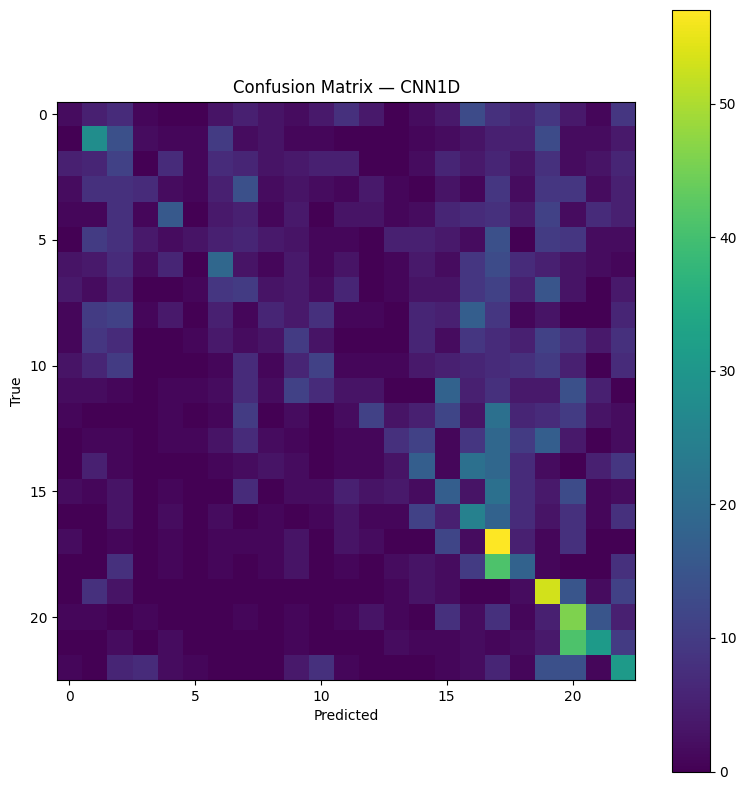

Saved: ../reports/db1/cm_cnn1d.png


In [30]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true_all, y_pred_all)

fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(cm, interpolation="nearest")
ax.set_title("Confusion Matrix — CNN1D")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.colorbar(im, ax=ax)
plt.tight_layout()

fig_path = REPORTS_DIR / "cm_cnn1d.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved:", fig_path)

In [31]:
ckpt_path = MODELS_DIR / "cnn1d_db1.pt"
meta_path = MODELS_DIR / "cnn1d_db1_meta.npz"

torch.save(model.state_dict(), ckpt_path)
np.savez_compressed(meta_path, n_channels=n_channels, n_classes=n_classes)

print("Saved model to:", ckpt_path)
print("Saved meta   to:", meta_path)

Saved model to: ../models/db1/cnn1d_db1.pt
Saved meta   to: ../models/db1/cnn1d_db1_meta.npz


In [33]:
def predict_logits(x_np):  # x_np: (T,C)
    x = torch.from_numpy(np.transpose(x_np.astype(np.float32), (1,0))).unsqueeze(0).to(DEVICE)  # (1,C,T)
    with torch.no_grad():
        logits = model(x).cpu().numpy()[0]
    return logits

# demo with one test sample
log = predict_logits(Xte[1])
pred = log.argmax()
print("pred idx:", pred, " true:", yte[0])

pred idx: 22  true: 0
